# An efficient mobile application of image classification to detect plant disease from leaves using MobileNet

In [7]:
#Import TensorFlow and other necessary libraries

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
import glob

In [9]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [10]:
#Specify directory for train and test samples

train_dir ="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
test_dir="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


In [11]:
#Count the labels and samples

train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes
70295 Train images
17572 Test images


In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [14]:
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [15]:
#Compose the model

from keras.applications.mobilenet import MobileNet
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = Sequential()

model_finetuned.add(MobileNet(weights='imagenet'))
model_finetuned.add(BatchNormalization())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(38, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

17227776/17225924 [==============================] - 0s 0us/step


In [16]:
#Model summary

model_finetuned.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1000)              4253864   
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                4902      
Total params: 4,390,894
Trainable params: 156,918
Non-trainable params: 4,233,976
_________________________________________________________________


In [17]:
#Train and validate model

from keras.callbacks import ReduceLROnPlateau
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=8,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Found 17572 images belonging to 38 classes.
Epoch 1/8
2197/2197 [==============================] - 1344s 610ms/step - loss: 1.3938 - accuracy: 0.6311 - val_loss: 0.4774 - val_accuracy: 0.8589
Epoch 2/8
2197/2197 [==============================] - 992s 452ms/step - loss: 0.3335 - accuracy: 0.8910 - val_loss: 0.2814 - val_accuracy: 0.9155
Epoch 3/8
2197/2197 [==============================] - 997s 454ms/step - loss: 0.2057 - accuracy: 0.9315 - val_loss: 0.1778 - val_accuracy: 0.9431
Epoch 4/8
2197/2197 [==============================] - 999s 454ms/step - loss: 0.1460 - accuracy: 0.9503 - val_loss: 0.1295 - val_accuracy: 0.9590
Epoch 5/8
2197/2197 [==============================] - 994s 453ms/step - loss: 0.1083 - accuracy: 0.9638 - val_loss: 0.1070 - val_accuracy: 0.9653
Epoch 6/8
2197/2197 [==============================] - 988s 450ms/step - loss: 0.0866 - accuracy: 0.9707 - val_loss: 0.0856 - val_accuracy: 0.9718
Epoch 7/8
2197/2197 [==============================] - 999s 455ms/step - 

In [18]:
from keras.models import load_model
model_finetuned.save('plantdiseasemobilenet8epoch.h5')

[[3.32149042e-09 9.32050335e-13 9.16671539e-09 1.40444132e-11
  9.38223454e-09 8.64602523e-09 3.33342810e-13 6.97947034e-09
  3.58123101e-12 2.26736564e-11 3.16400009e-13 9.48232031e-12
  1.05025454e-10 4.55246431e-11 3.11510021e-14 3.37893991e-10
  2.56717647e-10 2.95621111e-10 1.79796686e-07 2.18948326e-09
  9.82231102e-11 3.44128684e-11 8.53840696e-12 2.76412093e-09
  1.45771004e-08 6.66744741e-12 1.11169608e-10 3.46373555e-11
  1.12020260e-08 7.17704074e-09 3.63903645e-08 1.97382732e-09
  7.48025253e-10 6.50912824e-10 4.08914369e-09 9.99999762e-01
  1.41624101e-09 2.09972324e-08]]


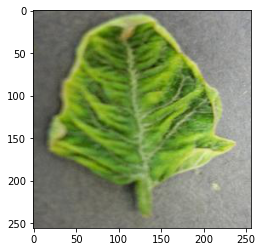

In [19]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=224
img_height=224
model_finetuned.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model_finetuned.predict([prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')])

disease=image.load_img('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')
plt.imshow(disease)
print(result)

In [20]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [21]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("plantdiseasemobilenet8epoch.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [22]:
model = converter.convert()
file = open( 'outputmobilenetof8epoch.tflite' , 'wb' ) 
file.write( model )

17448760

In [23]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="outputmobilenetof8epoch.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

[{'name': 'mobilenet_1.00_224_input', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

[{'name': 'Identity', 'index': 116, 'shape': array([ 1, 38], dtype=int32), 'shape_signature': array([-1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [24]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
input_data = [prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')]

In [25]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[3.32140804e-09 9.32048601e-13 9.16648801e-09 1.40442788e-11
  9.38228961e-09 8.64589289e-09 3.33338365e-13 6.97940417e-09
  3.58120369e-12 2.26736147e-11 3.16396405e-13 9.48235674e-12
  1.05025058e-10 4.55246466e-11 3.11507615e-14 3.37886913e-10
  2.56710320e-10 2.95613228e-10 1.79798079e-07 2.18942908e-09
  9.82259205e-11 3.44135241e-11 8.53837487e-12 2.76404699e-09
  1.45770178e-08 6.66734593e-12 1.11170032e-10 3.46374873e-11
  1.12020695e-08 7.17708160e-09 3.63898813e-08 1.97383110e-09
  7.48030970e-10 6.50920262e-10 4.08911260e-09 9.99999762e-01
  1.41623835e-09 2.09969109e-08]]


In [26]:
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

Tomato___Tomato_Yellow_Leaf_Curl_Virus


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


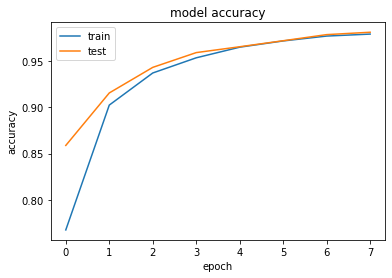

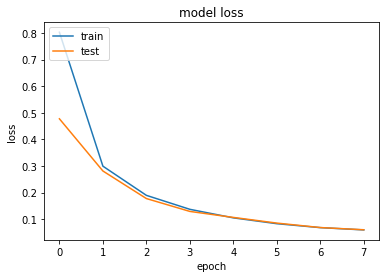

In [27]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()